In [1]:
# Import Necessary Packages

%matplotlib inline
import openmc
import numpy as np
from math import pi, sin, cos
import matplotlib.pyplot as plt

# For 3D plotting
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# ADD MATERIAL DEFINITIONS
# Fuel Material (MOX Fuels)
uranium = openmc.Material() # Depleted Uranium for ALFRED
uranium.add_nuclide('U234', 0.003)
uranium.add_nuclide('U235', 0.404)
uranium.add_nuclide('U236', 0.010)
uranium.add_nuclide('U238', 99.583)

plutonium = openmc.Material()
plutonium.add_nuclide('Pu238', 2.332)
plutonium.add_nuclide('Pu239', 56.873)
plutonium.add_nuclide('Pu240', 26.997)
plutonium.add_nuclide('Pu241', 6.105)
plutonium.add_nuclide('Pu242', 7.693)

oxygen = openmc.Material()
oxygen.add_element('O', 1.0)

uo2 = openmc.Material.mix_materials([uranium, oxygen],[0.3367, 0.6633])
puo2 = openmc.Material.mix_materials([plutonium, oxygen], [0.3367, 0.6633])

mox1 = openmc.Material.mix_materials([puo2, uo2], [0.217, 0.783], 'wo') # 21.7% PuO2 Enrichment
mox2 = openmc.Material.mix_materials([puo2, uo2], [0.278, 0.722], 'wo') # 27.8% PuO2 Enrichment

mox1.set_density('g/cm3', 11.07 * 0.95)    # Setting a density of 0.95 of theoretical density
mox2.set_density('g/cm3', 11.1 * 0.95)     # Setting a density of 0.95 of theoretical density

mox1.temperature = 1200
mox2.temperature = 1200

# Cladding Material (Ti-15-15 Steel)
clad = openmc.Material()
clad.add_element('Cr', 15, 'wo')
clad.add_element('Ni', 15, 'wo')
clad.add_element('Mo', 1.5, 'wo')
clad.add_element('Mn', 1.5, 'wo')
clad.add_element('Si', 0.9, 'wo')
clad.add_element('Ti', 0.4, 'wo')
clad.add_element('C', 0.09, 'wo')
clad.add_element('B', 0.006, 'wo')
clad.add_element('Fe', 65.604,'wo')
clad.set_density('g/cm3', 7.95)
clad.temperature = 900

# Coolant (Lead)
lead = openmc.Material()
lead.add_element('Pb', 1.0,)
lead.temperature = 700
lead.set_density('g/cm3', 10.6)
lead.depletable = True
lead.volume = 6134682.08   

# Gap (Helium)
he = openmc.Material()
he.add_element('He', 1)
he.set_density('g/cm3', 0.00016)
he.temperature= 700
 
# Absorber (Boron Carbide)
b4c = openmc.Material()
b4c.add_element('B', 4.0, enrichment=90, enrichment_target='B10', enrichment_type='wo')
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 2.2)
b4c.temperature = 700

# Reflector (Yttria-Stabilized Zirconia)
zirconia = openmc.Material()
zirconia.add_elements_from_formula('ZrO2', 'ao', 1.0)

yttria = openmc.Material()
yttria.add_elements_from_formula('Y2O3', 'ao', 1.0)

ysz = openmc.Material.mix_materials([zirconia, yttria], [0.95, 0.05], 'wo')
ysz.temperature = 700
ysz.set_density('g/cm3', 6.08)

mat = openmc.Materials([mox1, mox2, clad, he, lead, b4c, ysz])
mat.export_to_xml()

In [3]:
# ADD PRIMARY GEOMETRY DEFINITIONS
# Surfaces
fuel_ir = openmc.ZCylinder(r=0.1)
fuel_or = openmc.ZCylinder(r=0.45)
clad_ir = openmc.ZCylinder(r=0.465)
clad_or = openmc.ZCylinder(r=0.525)

top = openmc.ZPlane(z0=+30)
bottom = openmc.ZPlane(z0=-30)
cr_top = openmc.ZPlane(z0=-24)
cr_down = openmc.ZPlane(z0=-84.5)
up = openmc.ZPlane(z0=+42, boundary_type='vacuum')
down = openmc.ZPlane(z0=-85, boundary_type='vacuum')

# Regions
center_region = -fuel_ir & -up & +down
fuel_region = +fuel_ir & -fuel_or & -top & +bottom
gap_region = +fuel_or & -clad_ir & -top & +bottom
clad_region = +clad_ir & -clad_or & -top & +bottom
coolant_region = +clad_or & -up & +down

In [4]:
# Define Inner Assembly Fuel Pins
center_cell1 = openmc.Cell(region=center_region)
fuel_cell1 = openmc.Cell(fill=mox1, region=fuel_region)
gap_cell1 = openmc.Cell(fill=he, region=gap_region)
clad_cell1 = openmc.Cell(fill=clad, region=clad_region)
coolant_cell1 = openmc.Cell(fill=lead, region=coolant_region)

fuel_u1 = openmc.Universe(cells=[center_cell1, fuel_cell1, gap_cell1, clad_cell1, coolant_cell1])

In [5]:
# Define Inner Fuel Assembly
all_lead_out = openmc.Cell(fill=lead)
all_lead_out_u = openmc.Universe(cells=[all_lead_out])
in_lat = openmc.HexLattice(name='inner_fuel_assembly')
in_lat.center = (0., 0.)
in_lat.pitch = (1.386,)
in_lat.outer = all_lead_out_u

in_ring6 = [fuel_u1]*36
in_ring5 = [fuel_u1]*30
in_ring4 = [fuel_u1]*24
in_ring3 = [fuel_u1]*18
in_ring2 = [fuel_u1]*12
in_ring1 = [fuel_u1]*6
in_ring0 = [fuel_u1]

in_lat.universes = [in_ring6, in_ring5, in_ring4, in_ring3, in_ring2, in_ring1, in_ring0]
in_lat.orientation = 'y'

outer_in_surface = openmc.model.HexagonalPrism(edge_length=9.0, orientation='y')

main_in_assembly = openmc.Cell(fill=in_lat, region=-outer_in_surface & -top & +bottom)

in_plenum_top = openmc.Cell(fill=lead, region= -outer_in_surface & -up & +top)
in_plenum_bottom = openmc.Cell(fill=lead, region= -outer_in_surface & +down & -bottom)

out_in_assembly = openmc.Cell(fill=lead, region=+outer_in_surface & -up & +down)

main_in_u = openmc.Universe(cells=[main_in_assembly, out_in_assembly, in_plenum_bottom, in_plenum_top])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

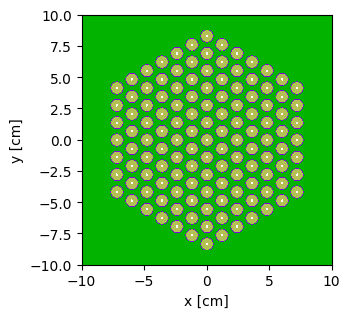

In [6]:
# Plot Inner Assembly
main_in_u.plot(width=(20,20), pixels=(250,250), color_by='material')

In [7]:
# Define Outer Assembly Fuel Pins
center_cell2 = openmc.Cell(region=center_region)
fuel_cell2 = openmc.Cell(fill=mox2, region=fuel_region)
gap_cell2 = openmc.Cell(fill=he, region=gap_region)
clad_cell2 = openmc.Cell(fill=clad, region=clad_region)
coolant_cell2 = openmc.Cell(fill=lead, region=coolant_region)

fuel_u2 = openmc.Universe(cells=[center_cell2, fuel_cell2, gap_cell2, clad_cell2, coolant_cell2])

In [8]:
# Define Outer Fuel Assembly
out_lat = openmc.HexLattice(name='assembly')
out_lat.center = (0., 0.)
out_lat.pitch = (1.386,)
out_lat.outer=all_lead_out_u
out_lat.orientation = 'y'

out_ring6 = [fuel_u2]*36
out_ring5 = [fuel_u2]*30
out_ring4 = [fuel_u2]*24
out_ring3 = [fuel_u2]*18
out_ring2 = [fuel_u2]*12
out_ring1 = [fuel_u2]*6
out_ring0 = [fuel_u2]

out_lat.universes = [out_ring6, out_ring5, out_ring4, out_ring3, out_ring2, out_ring1, out_ring0]

outer_out_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')

main_out_assembly = openmc.Cell(fill=out_lat, region=-outer_out_surface & -top & +bottom)

out_plenum_top = openmc.Cell(fill=lead, region=-outer_out_surface & -up & +top)
out_plenum_bottom = openmc.Cell(fill=lead, region=-outer_out_surface & +down & -bottom)

out_out_assembly = openmc.Cell(fill=lead, region=+outer_out_surface & -up & +down)

main_out_u = openmc.Universe(cells=[main_out_assembly, out_out_assembly, out_plenum_bottom, out_plenum_top])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

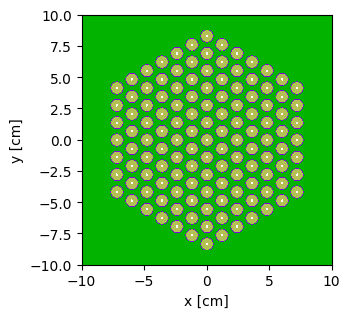

In [9]:
# Plot Outer Assembly
main_out_u.plot(width=(20,20), pixels=(250,250), color_by='material')

In [10]:
# Define Shutdown Rod
outer_sr_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')
sr_cell = openmc.Cell(fill=lead, region=-outer_sr_surface & -up & +down)
out_sr_cell = openmc.Cell(fill=lead, region=+outer_sr_surface & -up & +down)
sr_u = openmc.Universe(cells=[sr_cell, out_sr_cell])

In [11]:
# Define Control Rod

calendria_ir = 6.44780
calendria_or = 6.58750
r_rod = 1.48
r_clad = 1.53

ring_radii = np.array([0.0, 3.2, 6.2])

# These are the surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

lead_cells = []
for i in range(ring_radii.size):
    # Create annular region
    if i == 0:
        lead_region = -radial_surf[i]  & -up & +down
    elif i == ring_radii.size - 1:
        lead_region = +radial_surf[i-1]  & -up & +down
    else:
        lead_region = +radial_surf[i-1] & -radial_surf[i]  & -up & +down
        
    lead_cells.append(openmc.Cell(fill=lead, region=lead_region  & -up & +down))

cr_u = openmc.Universe(cells=lead_cells)

# Pin Universe
surf_rod = openmc.ZCylinder(r=r_rod)

rod_cell = openmc.Cell(fill=b4c, region=-surf_rod & -cr_top & +cr_down)
clad_cell = openmc.Cell(fill=clad, region=+surf_rod  & -cr_top & +cr_down)

pin_universe = openmc.Universe(cells=(rod_cell, clad_cell))

num_pins = [1, 6, 12]
angles = [0, 30, 15]

cr_top_cell=openmc.Cell(fill=lead, region=-up & +cr_top)
cr_down_cell=openmc.Cell(fill=lead, region=+down & -cr_down)
cr_cyl_ir = openmc.ZCylinder(r=8)
cr_cyl_or = openmc.ZCylinder(r=8.5)

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        # Determine the location of center of pin
        theta = (a + j/n*360.) * pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_clad)
        lead_cells[i].region &= +pin_boundary  
        
        # Create each fuel pin -- note that we explicitly assign an ID so 
        # that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary & -cr_top & +cr_down)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        cr_u.add_cell(pin)
        cr_u.add_cell(cr_top_cell)
        cr_u.add_cell(cr_down_cell) 

In [12]:
# Define Dummy/Reflector
outer_dummy_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')
dummy_cell = openmc.Cell(fill=ysz, region=-outer_dummy_surface & -up & +down)
out_dummy_cell = openmc.Cell(fill=lead, region=+outer_dummy_surface & -up & +down)
dummy_u = openmc.Universe(cells=[dummy_cell, out_dummy_cell])

In [13]:
# Empty
outer_empty_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')
empty_cell = openmc.Cell(fill=lead, region= None)
out_empty_cell = openmc.Cell(region= None)
empty_u = openmc.Universe(cells=[empty_cell,out_empty_cell])

In [14]:
# Define Core Geometry
core_lat = openmc.HexLattice(name='core')
core_lat.center = (0., 0.)
core_lat.pitch = (16.6,)
core_lat.outer = all_lead_out_u
core_lat.orientation = 'x'

core_ring10 =  ([empty_u]*3 + [dummy_u]*5 + [empty_u]*2)*6
core_ring9 = ([empty_u] + [dummy_u]*8)*6
core_ring8 = ([dummy_u]*3 + [main_out_u]*3 + [dummy_u]*2 )*6 
core_ring7 = [main_out_u]*42
core_ring6 = [main_out_u, main_out_u, cr_u, main_out_u, cr_u, main_out_u]*6
core_ring5 = [main_out_u]*30
core_ring4 = [main_in_u]*24
core_ring3 = [main_in_u]*18
core_ring2 = [sr_u, main_in_u, main_in_u]*4
core_ring1 = [main_in_u]*6
core_ring0 = [main_in_u]*1
core_lat.universes = [core_ring10, core_ring9, core_ring8, core_ring7, core_ring6, core_ring5, core_ring4, core_ring3, core_ring2, core_ring1, core_ring0]

outer_core_surface = openmc.ZCylinder(r=160, boundary_type='vacuum')

core = openmc.Cell(fill=core_lat, region=-outer_core_surface & -up & +down)

main_u = openmc.Universe(cells=[core])

geom = openmc.Geometry(main_u)
geom.export_to_xml()

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

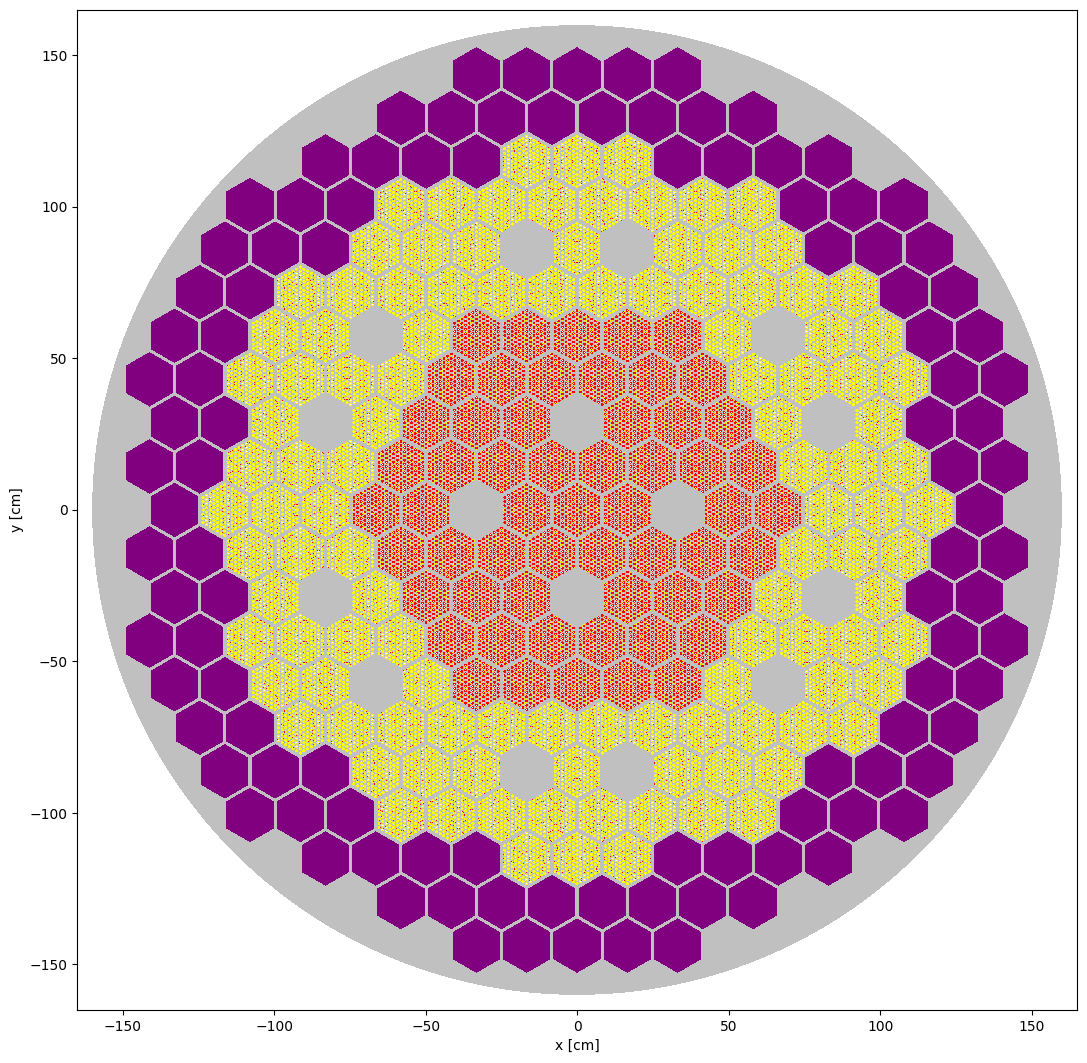

In [15]:
# Plot Core Geometry

core_material_colors = {
    mox1:'red',
    mox2:'yellow',
    b4c:'black',
    lead:'silver',
    clad:'yellow',
    ysz:'purple',
    he:'red'
}

main_u.plot(width=(330,330), pixels=(1000,1000), color_by='material', colors=core_material_colors)

# Increase values in pixels to get better images

In [16]:
# Settings
# Use variables for better usability in getting tallies from values
number_of_batches = 20
number_of_particles = 10000

settings = openmc.Settings()
settings.temperature = {'method':'interpolation'}
settings.batches = number_of_batches
settings.inactive = 5
settings.particles = number_of_particles
settings.export_to_xml()

In [17]:
# Instantiate a tally Mesh
d = 700 # Define how many meshes will the geometry be divided into
mesh = openmc.RegularMesh()
mesh.dimension = [d, d]
mesh.lower_left = [-160, -160]
mesh.upper_right = [+160, +160]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
flux_tally = openmc.Tally(name='flux_tally')
flux_tally.filters = [mesh_filter]
flux_tally.scores = ['flux']

In [18]:
# Creating a tally of fission-q-recoverable needed for normalization in [neutrons-cm/src] to [neutrons/cm^2-s]
H = openmc.Tally()
H.scores = ['heating-local']
H.filter = [mesh_filter]

tallies = openmc.Tallies([H, flux_tally])
tallies.export_to_xml()

In [19]:
# Run OpenMC and load the statepoint files in sp
openmc.run()

sp = openmc.StatePoint(f'./statepoint.{number_of_batches}.h5', autolink=False)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [25]:
# Now we need to normalize the units from [n/cm-src] to [n/cm^2-s]

# Calculating the Volume of Mesh
# Calculating the Volume of Mesh
mesh_length = (mesh.upper_right[0] - mesh.lower_left[0]) / d
mesh_width = (mesh.upper_right[1] - mesh.lower_left[1]) / d
mesh_height = 60

volume = mesh_length * mesh_width * mesh_height

# Calculating the Factor to Normalize the Flux
power = 300e6
H_value = sp.tallies[H.id].get_pandas_dataframe()['mean'][0]
H_Jsrc = 1.602e-19 * H_value

fission_normalization_factor = power / H_Jsrc
flux_normalization_factor = fission_normalization_factor/volume

In [26]:
# Getting the Flux Values in DataFrame
df = sp.tallies[flux_tally.id].get_pandas_dataframe()

normalized_flux = df['mean'] * flux_normalization_factor

normalized_flux_array = normalized_flux.to_numpy()  # From Pandas Series to NumPy array
normalized_flux_2d = normalized_flux_array.reshape((d, d)) # Reshaping to 2D array for plotting the radial distribution

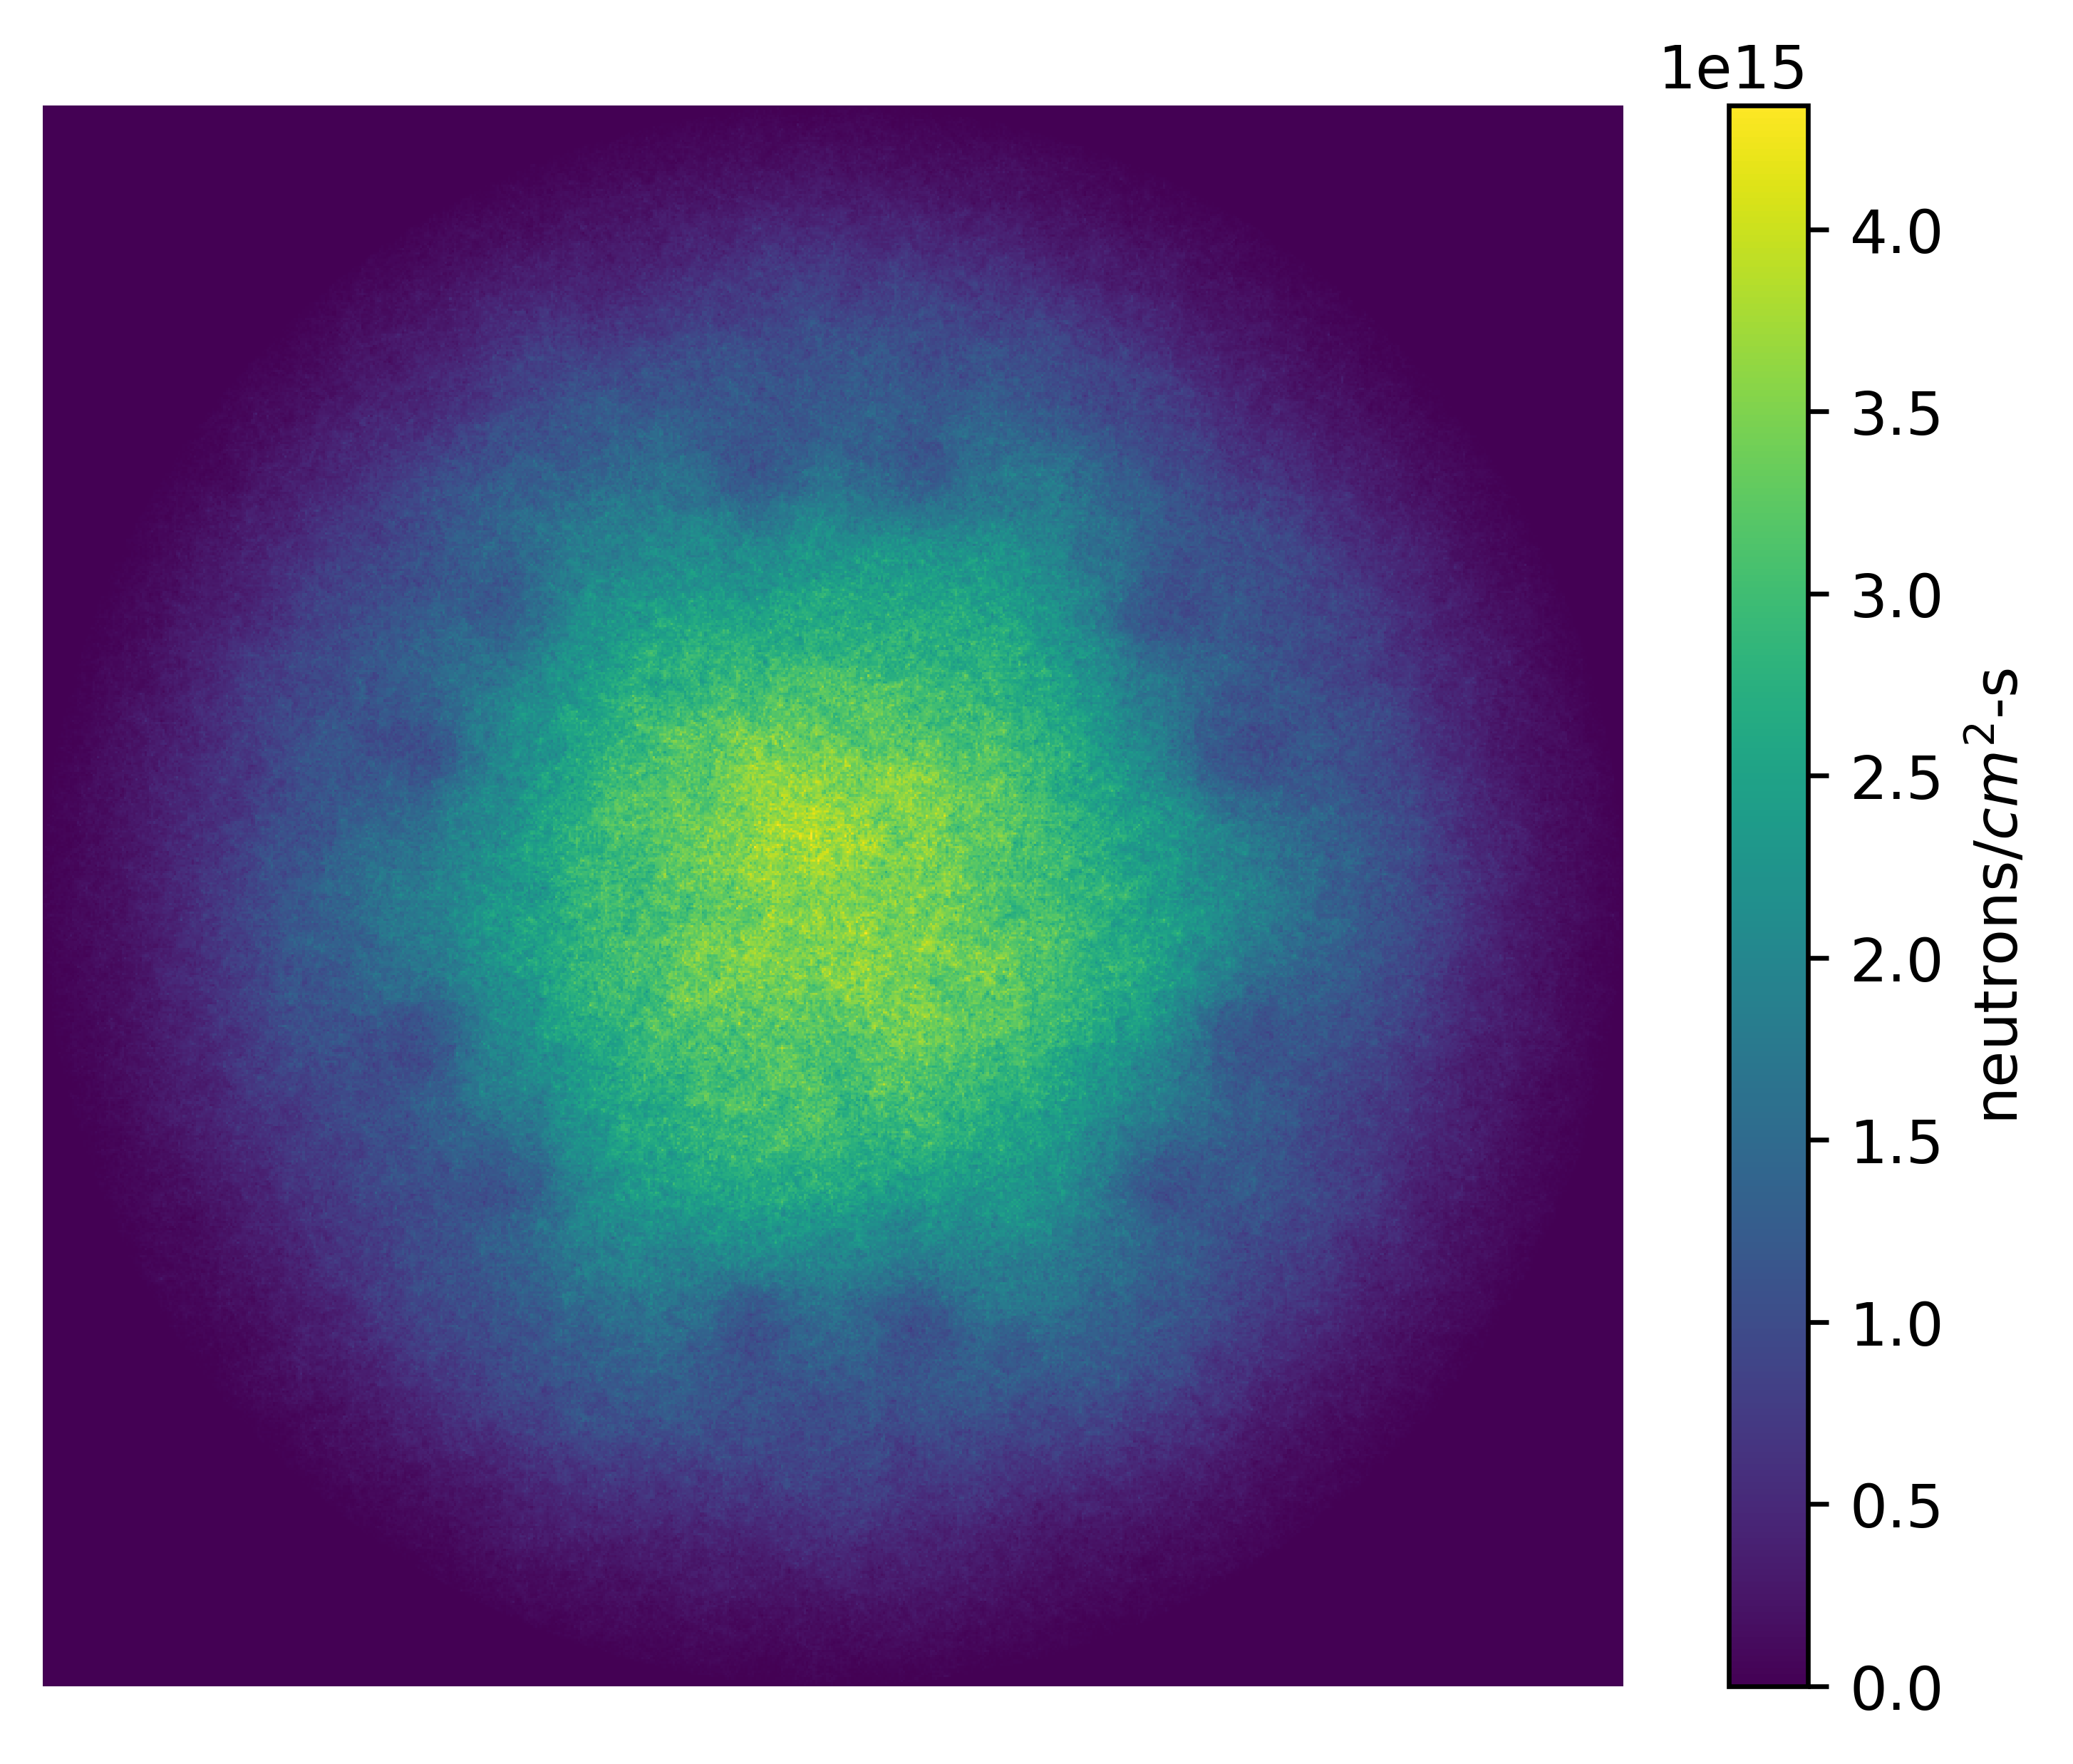

In [27]:
# Plotting 2D Radial Flux Distribution
dpi = 600 # For good quality image

plt.figure(dpi=dpi)
plt.imshow(normalized_flux_2d, interpolation='none', origin='lower', cmap='viridis')
plt.colorbar(orientation='vertical', label='neutrons/$cm^2$-s')
plt.axis('off')  # Removes axis ticks and labels for a clean visualization
plt.savefig("./flux_distribution.png", dpi=dpi, bbox_inches='tight')
plt.show()
plt.close()

In [28]:
# Getting the maximum, minimum and average flux values

min_flux = normalized_flux[normalized_flux > 0].min()
max_flux = normalized_flux[normalized_flux > 0].max()
mean_flux = normalized_flux[normalized_flux > 0].mean()

print('Average Neutron Flux:', mean_flux)
print('Minimum Neutron Flux:', min_flux)
print('Maximum Neutron Flux:', max_flux)

Average Neutron Flux: 1185730332282080.0
Minimum Neutron Flux: 894105724.2060939
Maximum Neutron Flux: 4339658317819829.0
